In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from molvecgen.vectorizers import SmilesVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas, numpy, random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
baseline = 2.5

In [3]:
class SMILESMolDataset(Dataset):
    def __init__(self, molecules, y, vectorizer):
        self.molecules = molecules
        self.y = y
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.molecules)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        mols = self.molecules[idx]
         
        #The vectorizer was written to work with batches, 
        #but PyTorch datasets unfortunately works with single samples
        sample = self.vectorizer.transform([mols])[0]
        label = float(self.y[idx] > baseline)
        #print("self.y[idx]", self.y[idx], 'label', label)

        target = torch.FloatTensor([label])
        
        return sample, label, target

,smiles,mu,alpha,homo,lumo,gap,r2,zpve,cv,u0,u298,h298,g298,Molecule
200,Cc1cc[nH]c1,1.6978,55.32,-0.1982,0.0533,0.2515,528.9258,0.109903,20.948,-249.395323,-249.389640,-249.388696,-249.424242,
201,Cc1c[nH]cn1,3.3147,51.32,-0.2157,0.0376,0.2533,500.6403,0.098598,19.536,-265.457424,-265.451994,-265.451050,-265.486153,
202,Cc1ccoc1,0.8398,51.11,-0.2183,0.0250,0.2434,512.5694,0.097541,19.399,-269.263476,-269.258130,-269.257186,-269.292093,

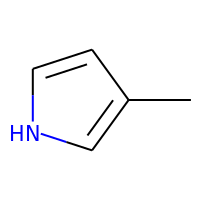
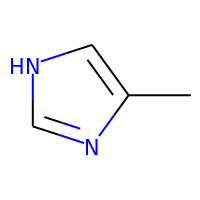
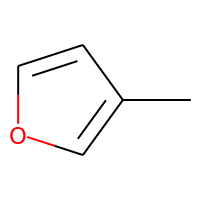

In [4]:
# whole data
dataset = pandas.read_csv('dataset/qm9.csv')
# small dataset
#dataset = pandas.read_csv('dataset/qm9.csv',skiprows=lambda i: i % 2 != 0 and i == 0,nrows=6000)
PandasTools.AddMoleculeColumnToFrame(dataset,'smiles','Molecule')

# Smiles Vectorizer
smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)
smivec.fit(dataset.Molecule.values, )

# test dataset
dataset[200:203]

In [5]:
# x_data, y_data are the data for Discriminator
x_train, x_data, y_train, y_data = train_test_split(dataset[['smiles','Molecule']].values, dataset['mu'].values, test_size=0.5)
x_train = pd.DataFrame(x_train, columns=['smiles','Molecule'])
x_data = pd.DataFrame(x_data, columns=['smiles','Molecule'])

print('length of x_train:',len(x_train),'x_data',len(x_data),'y_train', len(y_train), 'y_data', len(y_data))


length of x_train: 66942 x_data 66943 y_train 66942 y_data 66943


In [6]:
max_mu = max(y_data)
min_mu = min(y_data)
number_of_data = len(y_data)

number1 = len(y_data[y_data > baseline])
number2 = len(y_data[y_data <= baseline])
print(' > baseline', number1, ' <= baseline', number2)
print("number_of_data", number_of_data, "max_mu", max_mu, "min_mu", min_mu)


 > baseline 33588  <= baseline 33355
number_of_data 66943 max_mu 29.5564 min_mu 0.0


In [7]:
# functions to generate random data
def generate_random_seed_G(size):
    random_data = torch.randn(size)
    return random_data


def generate_random_value(size):
    random_data = np.random.randint(0, baseline * 2,(1, size))
    random_data = torch.FloatTensor(random_data)
    return random_data.view(-1)

def generate_random_label(size):
    random_data = np.random.randint(0, 2,(1, size))
    random_data = torch.FloatTensor(random_data)
    return random_data.view(-1)

# Fix a bug of view
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

print(generate_random_value(5))
print(generate_random_label(5))

tensor([3., 2., 0., 4., 1.])
tensor([0., 0., 1., 1., 1.])


In [8]:
# dataset for Generator, we 'Molecule' data will be used and actually ignore y_data in Generator, instead we use
# random value, but keeping it simple, we shape one SMILESMolDataset class.
data_dataset = SMILESMolDataset(x_data['Molecule'], y_data, smivec)
print('data_dataset[10]', data_dataset[10], 'y_data', y_data[10] )

data_dataset[10] (array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
   

In [9]:
# the dataset for Discriminator, the Discriminator will tell Generator the result is good/bad by model the train_dataset.
train_dataset = SMILESMolDataset(x_train['Molecule'], y_train, smivec)
train_dataset[10]

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],

In [10]:
# return a random SMILES 
def generate_random_seed(size):
    index_list = np.random.randint(1, number_of_data, (1, size))[0]
    random_data = []
    for i in index_list:
          random_data.append( data_dataset[i] )
    return random_data

generate_random_seed(2)[0][1]

1.0

In [11]:
# Will stop the epochs manually, so we set a large number let it keep running
#epochs = 5000
epochs = 5

# Smivec dimenstion, will pass to model
dims = smivec.dims
batch_size = 1   # The mini_batch size during training
#batch_size = 128   # The mini_batch size during training
G_input_size = 100 # The Generator input data size



############################## major turning parameters ##############################
#learning_rate_D = 0.003  # The Discriminator initial learning rate for the optimizer 
#learning_rate_G = 0.001  # The Generator initial learning rate for the optimizer


#learning_rate_D = 0.003  # The Discriminator initial learning rate for the optimizer 
#learning_rate_G = 0.003  # The Generator initial learning rate for the optimizer


# Accuracy    Run
# 0.388     30000
#learning_rate_D = 0.007  # The Discriminator initial learning rate for the optimizer 
#learning_rate_G = 0.005  # The Generator initial learning rate for the optimizer


# D: 1000, G:2000
# Accuracy    Run
# 0.639     30000
# 0.695     60000
#learning_rate_D = 0.005  # The Discriminator initial learning rate for the optimizer 
#learning_rate_G = 0.005  # The Generator initial learning rate for the optimizer


# Accuracy    Run
# 0.350     60000
#learning_rate_D = 0.05  # The Discriminator initial learning rate for the optimizer 
#learning_rate_G = 0.005  # The Generator initial learning rate for the optimizer

# Accuracy    Run
# 0.254     30000
#learning_rate_D = 0.001  # The Discriminator initial learning rate for the optimizer 
#learning_rate_G = 0.005  # The Generator initial learning rate for the optimizer


# D: 1000, G:2000
# Accuracy    Run
# 0.511     150000
#learning_rate_D = 0.0005  # The Discriminator initial learning rate for the optimizer 
#learning_rate_G = 0.0005  # The Generator initial learning rate for the optimizer


# D: 1000, G:2000
# Accuracy    Run
# 0.771       150000
#             300000
#learning_rate_D = 0.00075 # The Discriminator initial learning rate for the optimizer 
#learning_rate_G = 0.00075  # The Generator initial learning rate for the optimizer

# D: 50000, G:50000
# 0.517     1008,000 
# 0.692     1500,000 
#learning_rate_D = 0.00075 # The Discriminator initial learning rate for the optimizer 
#learning_rate_G = 0.00075  # The Generator initial learning rate for the optimizer


#################################### some data share, some difference ######################################
# Accuracy    Run
# 0.657     60000
#learning_rate_D = 0.00075  # The Discriminator initial learning rate for the optimizer 
#learning_rate_G = 0.00075  # The Generator initial learning rate for the optimizer


# data: 4000 
# real data: 4000
# Accuracy       Run
# 0.75     5,086,000
# 0.52     2,628,000
#learning_rate_D = 0.00075  # The Discriminator initial learning rate for the optimizer 
#learning_rate_G = 0.00075  # The Generator initial learning rate for the optimizer

# data: 67000 
# real data: 6700
# Accuracy       Run
# 
# 
learning_rate_D = 0.00075  # The Discriminator initial learning rate for the optimizer 
learning_rate_G = 0.00075  # The Generator initial learning rate for the optimizer

In [12]:
# discriminator class
class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        length = dims[0] 
        number_tokens = dims[1] + 1  # add the label layer

        # define neural network layers
        self.model = nn.Sequential(
            View(length * number_tokens),
            nn.Linear(length * number_tokens, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 1),
            nn.Sigmoid()
        )
        
        
        # create loss function
        self.loss_function = nn.MSELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=learning_rate_D)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, input_tensor, label_tensor):
        #print("input_tensor.shape", input_tensor.shape, "label_tensor.shape", label_tensor.shape)
        # combine input and label
        x = torch.cat((input_tensor, label_tensor), -1)
        #print("x.shape", x.shape)
        return self.model(x)
        
        
    
    
    def train(self, inputs, label_tensor, targets):
        # calculate the output of the network Discriminator
        outputs = self.forward(inputs, label_tensor)
        
        if (outputs.shape != targets.shape):
            print("Generator loss function issue: outputs.shape != targets.shape", outputs.shape, targets.shape)

        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients 
        self.optimiser.zero_grad()
        # perform a backward pass
        loss.backward()
        # update weights
        self.optimiser.step()

        pass
    
    
    # the plot to check convergent
    def plot_progress(self):
        dataframe = pandas.DataFrame(self.progress, columns=['loss'])
        dataframe.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [13]:
# load data
from torch.utils.data import DataLoader
data_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True, num_workers=4,drop_last=True )


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [15]:
%%time
# test discriminator to check the ability to separate real data from random noise


D = Discriminator()
D.to(device)

for smiles,label, target in data_loader:
    # real data
    target = target.view(1).to(device)
    #print('0.before change label.shape', label.shape, 'smiles', smiles.shape, 'target.shape', target.shape)
    label = label.float().to(device)
    label = label.view(batch_size, 1, 1).repeat(1, smiles.shape[1], 1)
    
    #print('1.before change label.shape', label.shape, 'smiles', smiles.shape)
    D.train(smiles.to(device).float(), label, target)
    
    # fake data(the value is random)
    fake_input = []
    fake_label = []
    for item in generate_random_seed(batch_size):
        fake_input.append(item[0])
        fake_label.append(item[1])
    
    #print('fake_label', fake_label)
    target = torch.FloatTensor(fake_label).to(device)
    fake_input = torch.FloatTensor(fake_input).to(device)
    
    fake_label = torch.FloatTensor(fake_label).to(device)
#    #print('2.before change label.shape', fake_input.shape, 'fake_label', fake_label.shape)
    fake_label = fake_label.view(batch_size, 1, 1).repeat(1, fake_input.shape[1], 1)
    #print('fake_input.shape', fake_input.shape, 'fake_label.shape', fake_label.shape)
    D.train(fake_input, fake_label, target)
    
    pass

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
counter =  59000
counte

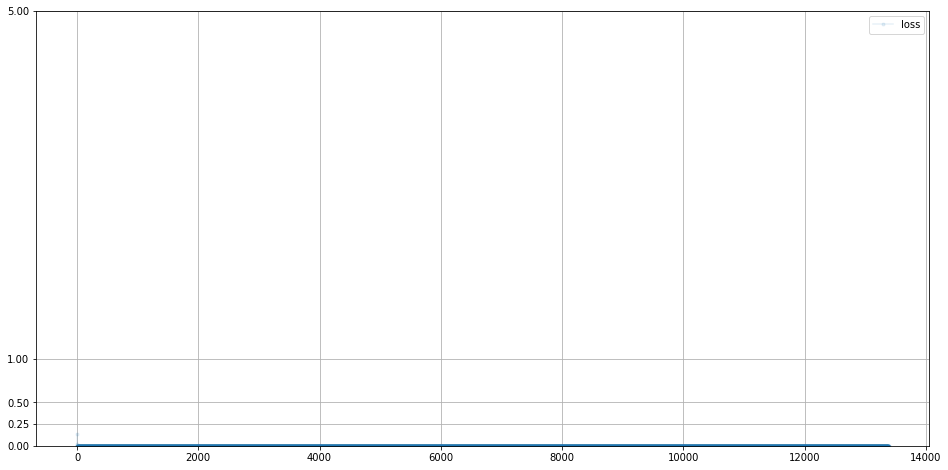

In [16]:
D.plot_progress()

In [17]:
# Test discriminator by real data 
i = 0
for smiles,label,target in data_loader:
    # real
    label = label.float().to(device)
    label = label.view(batch_size, 1, 1).repeat(1, smiles.shape[1], 1)
    result = D.forward(smiles.to(device).float(), label)
    print('label', label)
    print('result',result)
    
    i += 1
    if (i >= 1):
        break
    pass



label tensor([[[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.]]], device='cuda:0')
result tensor([1.0000], device='cuda:0', grad_fn=<SigmoidBackward>)


In [18]:
# Test discriminator by fale data
fake_input = []
fake_label = []
for item in generate_random_seed(batch_size):
    fake_input.append(item[0])
    fake_label.append(item[1])
    
#print('fake_label', fake_label)
target = torch.FloatTensor(fake_label).view(1,len(fake_label),1).to(device)
fake_input = torch.FloatTensor(fake_input).to(device)
    
fake_label = torch.FloatTensor(fake_label).to(device)
#    #print('2.before change label.shape', fake_input.shape, 'fake_label', fake_label.shape)
fake_label = fake_label.view(batch_size, 1, 1).repeat(1, fake_input.shape[1], 1)
result = D.forward(fake_input, fake_label)
#print('fake_input.shape', fake_input.shape, 'fake_label.shape', fake_label.shape)
print('fake_label', fake_label)
print('result', result) 


fake_label tensor([[[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.]]], device='cuda:0')
result tensor([1.0000], device='cuda:0', grad_fn=<SigmoidBackward>)


In [19]:
# generator class

class Generator(nn.Module):
    
    def __init__(self, batch_size):
        # initialise parent pytorch class
        super().__init__()
        
        self.batch_size = batch_size 
        self.model = nn.Sequential(
            nn.Linear(G_input_size * 2, 200),
            nn.LeakyReLU(0.02),
            #nn.LayerNorm(200),
            nn.Linear(200, number_of_data),
            nn.Sigmoid()

        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=learning_rate_G)
        
        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        self.stop = False
        
        pass
    
    
    def forward(self, seed_tensor, label_tensor):        
        # combine seed and label
        #print('Generator seed_tensor.shape', seed_tensor.shape, 'label_tensor', label_tensor.shape)
        inputs = torch.cat((seed_tensor, label_tensor))
        #print('after torch.cat', inputs.shape)
        outputs = self.model(inputs)
        #print('outputs', outputs)
        return torch.argmax(F.softmax(outputs, dim=0))


    def train(self, D, inputs, label_tensor, targets):
        # calculate the output of the network
        g_output = self.forward(inputs, label_tensor.repeat(G_input_size))
        #print('g_output', g_output)

        # we don't use the dataset generate label, we are using random value
        g_smiles, _, _ = data_dataset[g_output]
        
        g_input = torch.FloatTensor(g_smiles).to(device)
        g_input = g_input.reshape(1, g_input.shape[0], g_input.shape[1])
        
        g_label = label_tensor.repeat(1, g_input.shape[1], 1)
        
        # pass onto Discriminator
        #print("G g_input:", g_input.shape, "G_label", label_tensor.shape)
        
        d_output = D.forward(g_input, g_label)
        
        #print('d_output.shape', d_output.shape, 'targets.shape', targets.shape)
        if (d_output.shape != targets.shape):
            print("Generator loss function issue: d_output.shape != targets.shape", d_output.shape, targets.shape)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        
        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()


        pass
    

    def get_smiles(self, label):
        label_tensor = torch.zeros((G_input_size))
        for i in range(G_input_size):
            label_tensor[i] = label
    
        fake_input = torch.FloatTensor(generate_random_seed_G(G_input_size)).to(device)
        fake_label = torch.FloatTensor(label_tensor).to(device)
        idx = G.forward(fake_input, fake_label).detach().cpu().numpy()
        #print('idx', idx, 'fake_input', fake_input.shape, 'fake_label.shape', fake_label.shape,  'result.shape', result.shape)
        
        #idx = self.get_index(G.forward(fake_input, fake_label)).detach().cpu().numpy()
    
        #data['smiles'].iloc[idx]
        return x_data['smiles'].iloc[idx]

    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [20]:
# check the generator output is of the right type and shape

G = Generator(1)
G.to(device)

#fake = generate_random_seed()
fake_input = torch.FloatTensor(generate_random_seed_G(G_input_size)).to(device)
fake_label = torch.FloatTensor(generate_random_value(G_input_size)).to(device)
idx = G.forward(fake_input, fake_label)
print('idx', idx)
data_dataset[idx]




idx tensor(34029, device='cuda:0')


(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],

In [21]:
G.get_smiles(1.0)

'C#Cc1nc(on1)C#C'

In [22]:
%%time

# train Discriminator and Generator
D = Discriminator()
D.to(device)
G = Generator(batch_size)
G.to(device)


for epoch in range(epochs):
    print ("epoch = ", epoch + 1)

    # train Discriminator and Generator
    for smiles,label,target in data_loader:
        #########################################################                   
        # train discriminator on true
        #########################################################   
        target = torch.FloatTensor(torch.ones(smiles.shape[0])).to(device)
        #print('0.before change label.shape', label.shape, 'smiles', smiles.shape, 'target.shape', target.shape)
        label = label.float().to(device)
        label = label.view(batch_size, 1, 1).repeat(1, smiles.shape[1], 1)
    
        #print('1.before change label.shape', label.shape, 'smiles', smiles.shape)
        D.train(smiles.to(device).float(), label, target)
        #########################################################                   
        # train discriminator on false
        # use detach() so gradients in G are not calculated
        #########################################################      
        # fake


        fake_input = torch.FloatTensor(generate_random_seed_G(G_input_size)).to(device)
        fake_label = torch.FloatTensor(generate_random_label(1)).to(device)
        idx = G.forward(fake_input, fake_label.repeat(G_input_size)).detach().cpu().numpy()
        g_smiles, _, _ = data_dataset[idx]
        
        g_input = torch.FloatTensor(g_smiles).to(device)
        g_input = g_input.reshape(1, g_input.shape[0], g_input.shape[1])
        g_label = fake_label.repeat(1, g_input.shape[1], 1)
        
        target = torch.FloatTensor(torch.zeros(len(fake_label))).to(device)
        #target = torch.FloatTensor([0.0]).to(device)
        D.train(g_input, g_label, target)
        
        #fake_input = []
        #fake_label = []
        #for item in generate_random_seed(batch_size):
        #    fake_input.append(item[0])
        #    fake_label.append(item[1])
    
        #print('fake_label', fake_label)
        #target = torch.FloatTensor(torch.zeros(len(fake_label))).to(device)
        #fake_input = torch.FloatTensor(fake_input).to(device)
        #fake_label = torch.FloatTensor(fake_label).to(device)
        ##print('2.before change label.shape', fake_input.shape, 'fake_label', fake_label.shape)
        #fake_label = fake_label.view(batch_size, 1, 1).repeat(1, fake_input.shape[1], 1)
        #print('fake_input.shape', fake_input.shape, 'fake_label.shape', fake_label.shape)
        #target = torch.FloatTensor([0.0]).to(device)
        #D.train(fake_input, fake_label, target)

        #########################################################                   
        # train generator
        #########################################################                   
        fake_input = torch.FloatTensor(generate_random_seed_G(G_input_size)).to(device)
        fake_label = torch.FloatTensor(generate_random_label(1)).to(device)
        #print('fake_label', fake_label)
        #print('fake_label.shape', fake_label.shape)
        #fake_label = fake_label.view(1,G_input_size,1)
        target = torch.FloatTensor([0.0]).to(device)
        G.train(D, fake_input, fake_label, target)
        
    pass
pass


epoch =  1
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
counter =  5

counter =  460000
counter =  461000
counter =  462000
counter =  463000
counter =  464000
counter =  465000
counter =  466000
counter =  467000
counter =  468000
counter =  469000
counter =  470000
counter =  471000
counter =  472000
counter =  473000
counter =  474000
counter =  475000
counter =  476000
counter =  477000
counter =  478000
counter =  479000
counter =  480000
counter =  481000
counter =  482000
counter =  483000
counter =  484000
counter =  485000
counter =  486000
counter =  487000
counter =  488000
counter =  489000
counter =  490000
counter =  491000
counter =  492000
counter =  493000
counter =  494000
counter =  495000
counter =  496000
counter =  497000
counter =  498000
counter =  499000
counter =  500000
counter =  501000
counter =  502000
counter =  503000
counter =  504000
counter =  505000
counter =  506000
counter =  507000
counter =  508000
counter =  509000
counter =  510000
counter =  511000
counter =  512000
counter =  513000
counter =  514000
counter = 

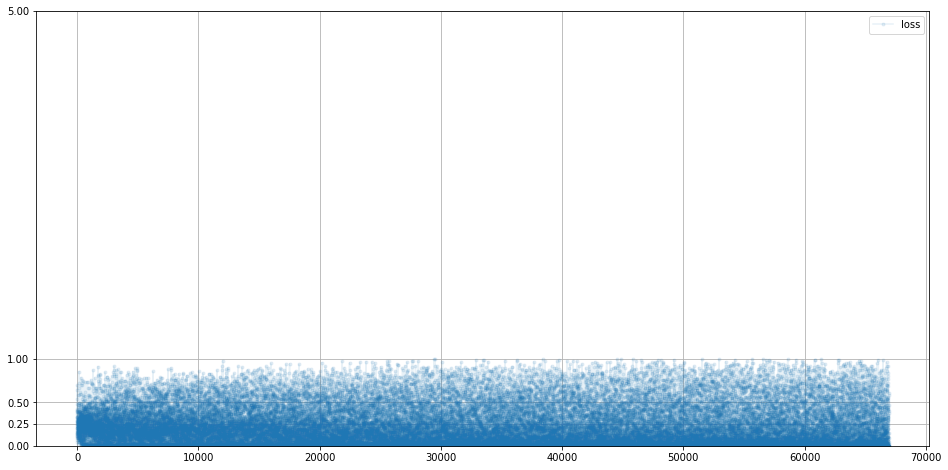

In [23]:
D.plot_progress()

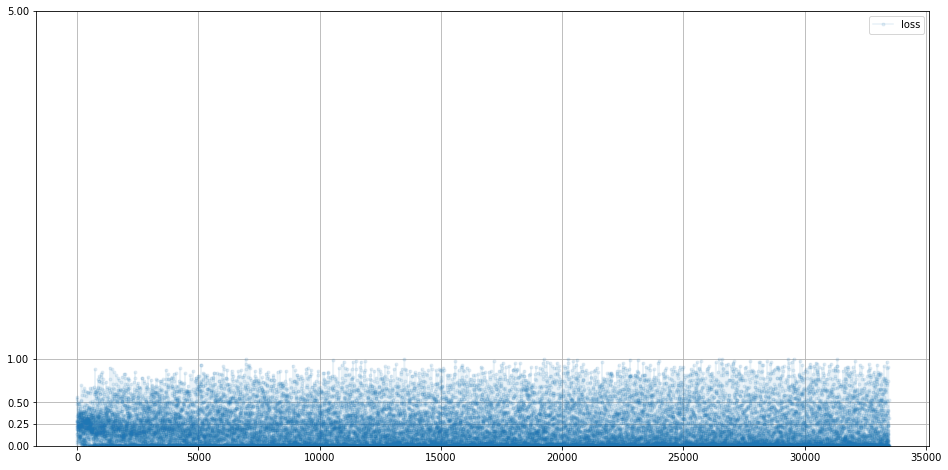

In [24]:
G.plot_progress()

In [25]:
qm9_dataset = pandas.read_csv('dataset/qm9.csv')
accuracy = []
number_of_verify = 1000
for i in range(number_of_verify):
    test_smiles = G.get_smiles(1.0)
    real = qm9_dataset[qm9_dataset['smiles'] == test_smiles ]
    #print('Test Result:', real.iat[0,0],real.iat[0,1], real.iat[0,1] > baseline)
    accuracy.append(real.iat[0,1] > baseline)
np.mean(accuracy)

0.603

In [26]:
i = 0
for smiles,label,target in data_loader:
    # real
    target = torch.FloatTensor([1.0]).view(1,1,1).repeat(1, smiles.shape[0] ,1).to(device)
    label = label.float().to(device)
    label = label.view(batch_size, 1, 1).repeat(1, smiles.shape[1], 1)
    
    #print(label)
    print(D.forward(smiles.to(device).float(), label))
    
    i += 1
    if (i >= 10):
        break
    pass



tensor([0.5939], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.8786], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.9615], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.7644], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.7910], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.6648], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.7554], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.4926], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.9480], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.8791], device='cuda:0', grad_fn=<SigmoidBackward>)


In [27]:
for i in range(10):
    fake_input = []
    fake_label = []
    for item in generate_random_seed(batch_size):
        fake_input.append(item[0])
        fake_label.append(item[1])
    
    
    fake_input = torch.FloatTensor(fake_input).to(device)
    
    #fake_input = fake_input.reshape(1, fake_input.shape[0], fake_input.shape[1])
    fake_label = torch.FloatTensor(fake_label).to(device)
    #print('2.before change label.shape', fake_input.shape, 'fake_label', fake_label.shape)
    fake_label = fake_label.view(batch_size, 1, 1).repeat(1, fake_input.shape[1], 1)
    #print('fake_input.shape', fake_input.shape, 'fake_label.shape', fake_label.shape)
    target = torch.FloatTensor([0.0]).view(1,1,1).repeat(1, fake_input.shape[0] ,1).to(device)
    print(D.forward(fake_input, fake_label))
    pass


tensor([0.5999], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.6322], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.7164], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.6287], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.8166], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.9600], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.4422], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.8438], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.9119], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.5547], device='cuda:0', grad_fn=<SigmoidBackward>)


In [28]:
fake_input = torch.FloatTensor(generate_random_seed_G(G_input_size)).to(device)
fake_label = torch.FloatTensor(generate_random_value(G_input_size)).to(device)
result = G.forward(fake_input, fake_label).detach()
idx = result.cpu().numpy()
print('result', result, 'idx', idx, 'fake_input', fake_input.shape, 'fake_label.shape', fake_label.shape,  'result.shape', result.shape)
        
#idx = self.get_index(G.forward(fake_input, fake_label)).detach().cpu().numpy()
print(x_data['smiles'].iloc[idx])

result tensor(62951, device='cuda:0') idx 62951 fake_input torch.Size([100]) fake_label.shape torch.Size([100]) result.shape torch.Size([])
CC1N2CC(=O)CC12C


In [29]:
import pickle
from datetime import datetime

now = datetime.now() 
date_time = now.strftime("%Y%m%d%H%M")
G_filename = 'pre_train_model/GAN20G' + date_time + '.sav'
print('save model to file:', G_filename)
pickle.dump(G, open(G_filename, 'wb'))

D_filename = 'pre_train_model/GAN20D' + date_time + '.sav'
print('save model to file:', D_filename)
pickle.dump(D, open(D_filename, 'wb'))


#G_model = pickle.load(open(G_filename, 'rb'))

save model to file: pre_train_model/GAN20G202104170947.sav
save model to file: pre_train_model/GAN20D202104170947.sav


In [30]:
from sklearn.metrics import *

def classification_metrics(Y_pred, Y_true):
    acc = accuracy_score(Y_true, Y_pred)
    # auc is not working here
    # roc_auc_score - Only one class present in y_true 
    auc_ = None
    '''
    try:
        auc_ = roc_auc_score(Y_true, Y_pred)
    except ValueError:
        pass
    '''
    
    precision = precision_score(Y_true, Y_pred, average='weighted')
    recall = recall_score(Y_true, Y_pred, average='weighted')
    f1score = f1_score(Y_true, Y_pred, average='weighted')
    return acc, auc_, precision, recall, f1score



In [31]:
qm9_dataset = pandas.read_csv('dataset/qm9.csv')

In [32]:
y_true = []
prodict = []
number_of_verify = 100
for i in range(number_of_verify):
    test_smiles = G.get_smiles(1.0)
    real = qm9_dataset[qm9_dataset['smiles'] == test_smiles ]
    #print('Test Result:', real.iat[0,0],real.iat[0,1], real.iat[0,1] > baseline)
    y_true.append(float(real.iat[0,1] > baseline) )
    prodict.append(1.0)

acc, auc_, precision, recall, f1score = classification_metrics(y_true, prodict)
print('acc', acc)
print('auc_', auc_)
print('precision', precision)
print('recall', recall)
print('f1score', f1score)


acc 0.64
auc_ None
precision 1.0
recall 0.64
f1score 0.7804878048780488


/home/tony/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
from torchsummary import summary
# summary(D, [(1, dims[1] , dims[0] ), (1, dims[1] , 1)])
